# CREDIT DEFAULT 


In [92]:
import numpy as np
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tqdm

import datetime

%matplotlib inline 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics

# Introduction

### The Data Source
We've been provided a credit default dataset that consists of 5380 records, each characterized by 19 distinct features. The feature set is diverse, including date values, numerical entries, and categorical variables. We will examine each feature type and devise strategies to deal with any NaN or infeasible values present in the dataset, which will prepare it for subsequent modeling.

### The Challenge
This is a tabular problem requiring us to execute a classification task, which is somewhat unique due to the dataset's imbalance. We'll explore methods such as resampling or using a model specifically designed for handling such cases to tackle this issue.

### The Strategy
Initially, our focus will be on data exploration and deducing relevant transformations based on our findings. Following this, we'll develop a processing pipeline. The dataset will be divided into three subsets: training, validation, and testing. The testing subset will be reserved until the very end to validate that our model has not been overfitted on the validation set. Subsequently, we will experiment with various models, identify the one with the most potential, and optimize its hyperparameters. Finally, we'll evaluate our ultimate performance on the test set and study the importance of each feature.

### The Performance Indicators
The performance of our model will be assessed using accuracy and ROC AUC score, which are standard metrics in classification tasks.

# 1. Exploration and transformation of the data

## 1.1. A first glance at the data 

In [93]:
data = pd.read_csv('data/CreditTraining.csv', parse_dates=[3, 4, 13, 17])
data.head(15)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
1,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
2,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
3,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L
4,6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36,1.0,C,2012-11-01,Sales,Owned,1,NaT,D


We can already delete the Id_Customer feature, which is a identification variable, but this role is already taken by our index, hence we have no reason to keep this value.

In [94]:
data = data.drop(columns=['Id_Customer'])

### Minor fixes 

The feature Net_Annual_Income is not considered as a float but as a string. To do so, we need to replace the ',' in '.' and then to convert the string to a float.

In [95]:
data['Net_Annual_Income'] = data['Net_Annual_Income'].str.replace(',', '.').astype(float)

## 1.2. Target Value

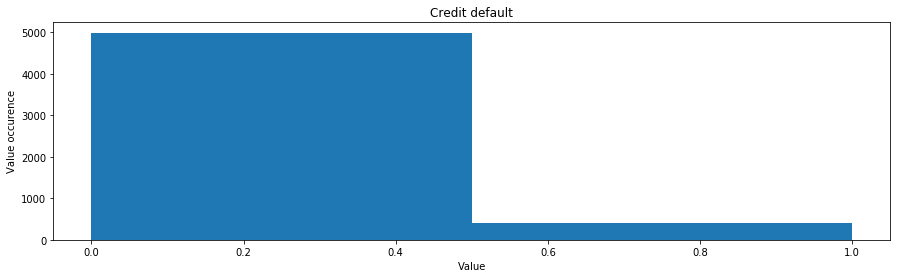

In [96]:
fig = plt.figure(figsize=(15, 4))
plt.hist(data['Y'], bins = 2)
plt.title("Credit default")
plt.ylabel('Value occurence')
plt.xlabel("Value")
# plt.grid()
plt.show()

It's evident that our data is heavily skewed. As a result, we should consider using a model designed to manage this imbalance effectively or alternatively, we could resample the data to achieve a more balanced distribution, especially if our aim is to use a neural network.

## 1.3. Managing Date Values

In this scenario, we're not processing the data as time series, as the specific timestamps aren't crucial. However, time deltas, or intervals between dates, are relevant to our case, so we'll convert these timestamps into time deltas and subsequently convert them into floating-point numbers by dividing them by a certain time unit!

We have the following date values:

-BirthDate
-Customer_Open_Date
-Prod_Decision_Date
-Prod_Closed_Date

Here are the transformations we'll apply:

-For Customer_Open_Date, we'll compute the difference in days between the most recent Customer_Open_Date and the current one, thereby obtaining a positive count of days.
-Instead of using the BirthDate, it's more reasonable to calculate the customer's age at the time of decision-making (i.e., Prod_Decision_Date). Therefore, we'll compute the number of days the customer has lived by the time the decision is made and assign this value to a new variable, Age_At_Decision.
Prod_Decision_Date will be expressed as the difference in days from the most recent one.
We'll adopt the same approach for Prod_Closed_Date.


In [97]:
ONE_DAY = datetime.timedelta(days = 1)

In [98]:
# open date
data['Customer_Open_Date'] = (data['Customer_Open_Date'].max() - data['Customer_Open_Date']) / ONE_DAY
# birthdate 
data['Age_At_Decision'] = (data['Prod_Decision_Date'] - data['BirthDate']) / ONE_DAY
data['BirthDate'] = (data['Prod_Decision_Date'].max() - data['BirthDate']) / ONE_DAY
# prod decision date
data['Prod_Decision_Date'] = (data['Prod_Decision_Date'].max() - data['Prod_Decision_Date']) / ONE_DAY

As there seems to be a huge correlation between the feature Prod_Closed_Date and the credit default, the high number of NaN is not sufficient at all to delete it ! We just replace them with 0.

In [99]:
data['Prod_Closed_Date'] = (data['Prod_Closed_Date'].max() - data['Prod_Closed_Date']) / ONE_DAY
data['Prod_Closed_Date'] = data['Prod_Closed_Date'].fillna(-1)

## 1.4. Let's explore the continuous features

We draw histograms for the continuous variables, see if we observe anything, maybe outliers...

### 1.4.1. Visualisation

In [100]:
CONTINUOUS_FEATURES = {
    'BirthDate': 100,
    'Customer_Open_Date': 100,
    'Number_Of_Dependant': 20,
    'Years_At_Residence': 60,
    'Net_Annual_Income': 100,
    'Years_At_Business': 100,
    'Prod_Decision_Date': 70,
    'Nb_Of_Products': 3,
    'Prod_Closed_Date': 30
}

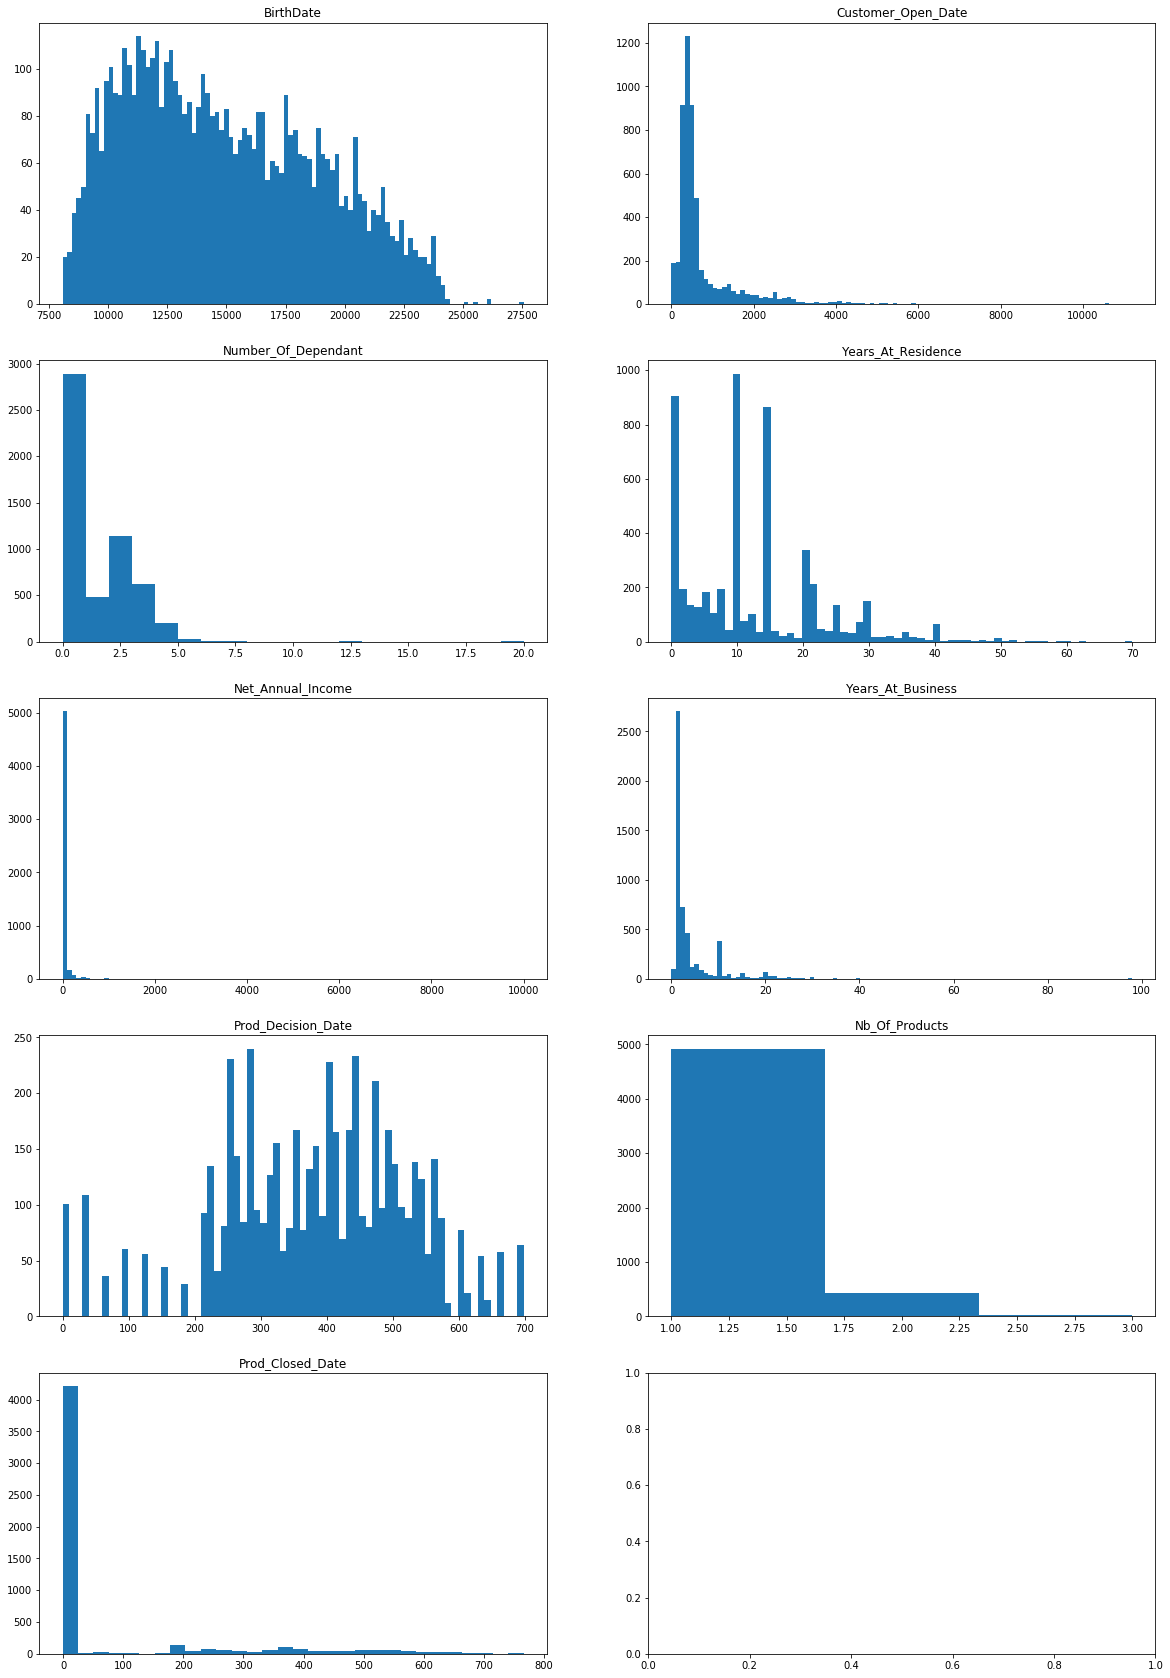

In [101]:
N = len(CONTINUOUS_FEATURES.keys())
Nx = N // 2 + N % 2

fig, axs = plt.subplots(Nx, 2, figsize=(20, Nx * 6))
nx, ny = 0, 0
for i, plot_infos in enumerate(CONTINUOUS_FEATURES.items()):
    feature, n_bins = plot_infos
    
    # manage plot
    axs[nx, ny].hist(data[feature], bins = n_bins)
    axs[nx, ny].set_title(feature)
    
    # generate new indices for the next subplot
    nx += (i%2 == 1)*1
    ny = 1 - i%2 
    
plt.show()

## 1.4.2 Evaluation
These graphical representations enable us to glean invaluable insights, prompting us to slightly modify the data.

-Regarding the Years_At_Business variable, there appear to be some anomalous values, around 100, which aren't realistic. We'll substitute these with more plausible values.

-We see a similar pattern with Customer_Open_Date, which is around 10000 days or approximately 30 years. However, these values are plausible and hence, we'll retain them.

-With respect to the Years_At_Residence variable, it's intriguing to notice extremely high spikes at around 10, 20, 30 years, suggesting that customers provided rounded-off answers. This indicates that the data is somewhat skewed and not evenly distributed, which could potentially be problematic for certain models like logistic regression. However, other models such as decision trees and XGBOOST, which we intend to use, are not impacted by such irregularities. As such, we will not adjust this aspect of the data.

### 1.4.3 Removing the outliers

**Modify unfeasible data**:
You cannot spend more years in a residence or working than you spend on earth... which is why we make sure that all the values are feasible, and if they are not, we replace them by feasible values ! Instead of taking the mean value, we use a approximate linear regression, saying that it is equal to 1 x Age + constant, with constant being 18 or 22.

In [102]:
data['Age'] = (data['BirthDate']) / (365)

In [103]:
for i in tqdm(range(data.shape[0])):
   diff_res = data['Age'][i] - data['Years_At_Residence'][i]
   diff_bus = data['Age'][i] - data['Years_At_Business'][i]
   if (diff_res < 0):
       data['Years_At_Residence'][i] = max(1, data['Age'][i] - 18)
   if (diff_bus < 10):
       data['Years_At_Business'][i] = max(1, data['Age'][i] - 22)

100%|██████████| 5380/5380 [00:00<00:00, 14779.20it/s]


In [104]:
data = data.drop(columns=['Age'])

### 1.4.3. Handle NaN values
We search were the NaN are.

In [105]:
data.isna().sum()

Y                      0
Customer_Type          0
BirthDate              0
Customer_Open_Date     0
P_Client               0
Educational_Level      0
Marital_Status         0
Number_Of_Dependant    2
Years_At_Residence     0
Net_Annual_Income      2
Years_At_Business      2
Prod_Sub_Category      0
Prod_Decision_Date     0
Source                 0
Type_Of_Residence      0
Nb_Of_Products         0
Prod_Closed_Date       0
Prod_Category          0
Age_At_Decision        0
dtype: int64

For the unfeasible data, we replaced absurd values thanks to a quick approximation of a linear regression. Here we can hardly do this, hence we simply replace the NaN values with the mean of the feature. 

In [106]:
nb_dep = data['Number_Of_Dependant'].mean()
data[data['Number_Of_Dependant'].isna()]

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category,Age_At_Decision
634,1,Existing Client,8187.0,806.0,P_Client,University,Single,NaN,21,33.6,1.0,C,230.0,Branch,Owned,2,249.0,G,7957.0
5045,0,Existing Client,22857.0,2999.0,NP_Client,Master/PhD,Married,NaN,10,50.0,10.0,C,222.0,Sales,Owned,1,-1.0,B,22635.0


In [107]:
data['Number_Of_Dependant'][634] = nb_dep
data['Number_Of_Dependant'][5045] = nb_dep

In [108]:
annual_inc = data['Net_Annual_Income'].mean()
# data[data['Net_Annual_Income'].isna()]
data['Net_Annual_Income'][1879] = annual_inc
data['Net_Annual_Income'][5144] = annual_inc

Except for the Years_At_Business were we use the same trick as before !

In [109]:
# data[data['Years_At_Business'].isna()]
data['Years_At_Business'][1987] = (data['BirthDate'][1987] / (365)) - 22
data['Years_At_Business'][2750] = (data['BirthDate'][2750] / (365)) - 22

In [110]:
# in case there is an issue 
data = data.fillna(value=0)

## 1.5. Let's explore the discrete features

### 1.5.1. Visualisation

Let us observe how the different categorical values are spread.

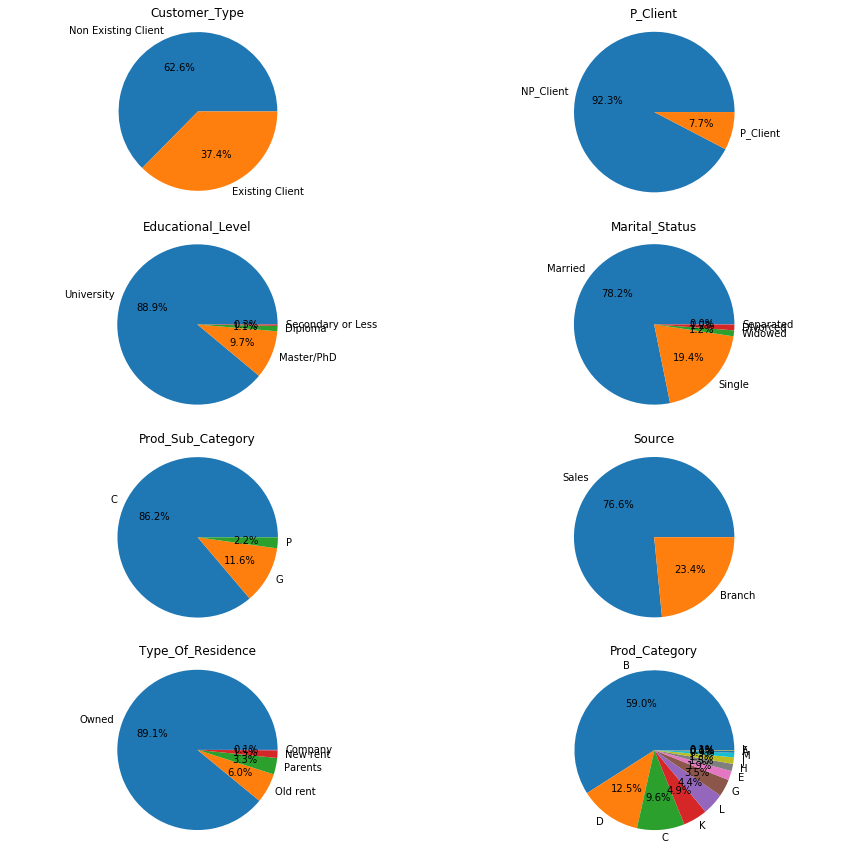

In [111]:
Categorical_Values = ['Customer_Type', 'P_Client', 'Educational_Level', 'Marital_Status','Prod_Sub_Category',
                     'Source', 'Type_Of_Residence', 'Prod_Category']

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for i in range(len(Categorical_Values)):
    cat = Categorical_Values[i]
    serie = data[cat].value_counts()
    labels = list(serie.index.values)
    sizes = list(serie.values)
    
    axs[i//2,i%2].pie(serie, labels = labels,autopct='%1.1f%%')
    axs[i//2,i%2].set_title(cat)
    axs[i//2,i%2].axis('equal')
    
plt.show()  

### 1.5.2. Analysis - Model Selection

There seems to be quite a large amount  of categories here, maby we can try to regroup some together, in order to have a simpler model.

Lets take a look at the Category Marital_Status in more detail :

In [112]:
Marital_Categories = ['Married',  'Single', 'Widowed', 'Separated', 'Divorced']
for let in Marital_Categories:
    print('------------------------------------------------------')
    print('Category '+ let)
    
    serie = data.loc[data['Marital_Status'] == let]['Y'].value_counts()
    
    print('Percent of negatives : ' + str((1 - serie[0]/serie.sum())*100))
    print('Size of category : '+ str(serie.sum()))

------------------------------------------------------
Category Married
Percent of negatives : 6.9186875891583455
Size of category : 4206
------------------------------------------------------
Category Single
Percent of negatives : 8.891013384321223
Size of category : 1046
------------------------------------------------------
Category Widowed
Percent of negatives : 6.25
Size of category : 64
------------------------------------------------------
Category Separated
Percent of negatives : 0.0
Size of category : 1
------------------------------------------------------
Category Divorced
Percent of negatives : 7.936507936507942
Size of category : 63


The category 'Separated' seems of very little importance considering its size. We will regroup it with the 'Divorced' category as they are semantically similar.

In [113]:
data['Marital_Status'].loc[data['Marital_Status'] == 'Separated'] = 'Separated_Or_Divorced'
data['Marital_Status'].loc[data['Marital_Status'] == 'Divorced'] = 'Separated_Or_Divorced'

When running our model whilst testing, we found out that quite a few categories of Prod_Category turned out having an extremely weak feature importance. For this reason, we regrouped them in a class called 'Regrouping_Class', allowing us to simplify the model.

In [114]:
data['Prod_Category'].loc[data['Prod_Category'] == 'A'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'E'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'F'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'G'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'I'] = 'Regrouping_Class'
data['Prod_Category'].loc[data['Prod_Category'] == 'J'] = 'Regrouping_Class'


These previous manipulations have allowed us to simplify the model. If we wonsider indicators such as BIC, these would now have a better value.

### 1.5.3. Label Encoding 


For some variables, we will simply use label encoding. The easiest is to apply label encoding to any categorical variable with only two levels. For these, there is no need to use One-Hot encoding.

In [115]:
le = LabelEncoder()
le.fit(data['Customer_Type'])

LabelEncoder()

In [116]:
list(le.classes_)

['Existing Client', 'Non Existing Client']

In [117]:
le.transform(data['Customer_Type']) 

array([1, 0, 1, ..., 1, 1, 1])

In [118]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


### 1.5.4. One Hot Encoding 

For the other variables, there exists a pandas function that allows us to create One Hot encoding immediately.

In [119]:
data = pd.get_dummies(data)

## 1.6. A last glance at our preprocessed dataset 

In [120]:
data.head()

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Decision_Date,...,Type_Of_Residence_Owned,Type_Of_Residence_Parents,Prod_Category_B,Prod_Category_C,Prod_Category_D,Prod_Category_H,Prod_Category_K,Prod_Category_L,Prod_Category_M,Prod_Category_Regrouping_Class
0,0,1,12933.0,295.0,0,3.0,1,36.0,1.0,294.0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,14054.0,1342.0,1,0.0,12,18.0,2.0,523.0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,14391.0,275.0,0,2.0,10,36.0,1.0,244.0,...,1,0,1,0,0,0,0,0,0,0
3,1,0,11077.0,467.0,0,3.0,3,36.0,1.0,514.0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,21658.0,64.0,0,2.0,1,36.0,1.0,33.0,...,1,0,0,0,1,0,0,0,0,0


# 2. Data scale and split 

## 2.1. Split the data: train, validate, test

In a real life situation as in a kaggle competition, we do not know the target values of the test set. To be in the same situation, we split our dataset in three parts: the train set, used to train our models, the validation set, used to estimate the quality of our model during our researches and the test set, which will only be used at the very end to see the final performance of our model.

In [121]:
features_name = data.columns[1:]
y, X = data[['Y']].values[:,0], data[features_name].values

In [122]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)

In [123]:
np.mean(y_train), np.mean(y_val), np.mean(y_test)

(0.07319198373511472, 0.06736353077816493, 0.07713754646840149)

## 2.2. Fit the scaler on the train data

To act like in a real situation, we scale on the train and not on the whole data set: when the bank create the model, it does not have access to the data that it will be doing prediction on in a few months...

In [124]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [125]:
X_train

array([[1.0000e+00, 1.1775e+04, 3.0700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 9.6780e+03, 5.6900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 2.0380e+04, 1.2200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 9.8340e+03, 4.8700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.4493e+04, 2.2700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.8087e+04, 9.3400e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [126]:
# transform train and validate 
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

# 3. Comparison of different models 

Let's fit three models and compare their performances

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

## 3.1. Use a Logistic Regression

In [128]:
model1 = LogisticRegression()
model1.fit(X_train_s, y_train)

y_train_pred = model1.predict(X_train_s)
y_train_predprob = model1.predict_proba(X_train_s)[:,1]

y_val_pred = model1.predict(X_val_s)
y_val_predprob = model1.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.946267789718269
ROC AUC (Train):         0.931651768615103

 --- VALIDATE
Accuracy :               0.9454123112659698
ROC AUC (Validate):      0.9195688581612058


## 3.2. Use a Decision Tree Classifier

In [129]:
model2 = DecisionTreeClassifier(random_state=0, max_depth=5)
model2.fit(X_train_s, y_train)

y_train_pred = model2.predict(X_train_s)
y_train_predprob = model2.predict_proba(X_train_s)[:,1]

y_val_pred = model2.predict(X_val_s)
y_val_predprob = model2.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9561428986349114
ROC AUC (Train):         0.9563174951376142

 --- VALIDATE
Accuracy :               0.9372822299651568
ROC AUC (Validate):      0.9390110362004551


## 3.3. Use a XGBoost Classifier

In [130]:
# use xgboost 
model3 = xgb.XGBClassifier(n_estimators = 50)

model3.fit(X_train_s, y_train)

# Predict training and validation set:
y_train_pred = model3.predict(X_train_s)
y_train_predprob = model3.predict_proba(X_train_s)[:,1]

y_val_pred = model3.predict(X_val_s)
y_val_predprob = model3.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9581760092942202
ROC AUC (Train):         0.9651251287102118

 --- VALIDATE
Accuracy :               0.9547038327526133
ROC AUC (Validate):      0.9525701034912182


We can observe that we get the best ROC AUC Score while using the **XGBoost Classifier**, hence we will use it as a final model. We still observe some overfitting as the results on the train set are consistently better than on the validation set, which is why it might be interesting to do some **parameter tuning**. 

# 4. Tuning of the model 
XGBoost is known as a very consistent model. Many of its hyperparameters do not need a lot of tuning. Nevertheless, the number of estimators is the one that can have a big influence on the final performance of the model. Let's tune it. 

In [131]:
N_ESTIMATORS_RANGE = [10, 20, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200]
train_scores = []
validate_scores = []

for n_estim in tqdm_notebook(N_ESTIMATORS_RANGE):
    model = xgb.XGBClassifier(n_estimators = n_estim)
    model.fit(X_train_s, y_train)

    # Predict training and validation set:
    y_train_predprob = model.predict_proba(X_train_s)[:,1]
    y_val_predprob = model.predict_proba(X_val_s)[:,1]

    train_scores.append(metrics.roc_auc_score(y_train, y_train_predprob))
    validate_scores.append(metrics.roc_auc_score(y_val, y_val_predprob))

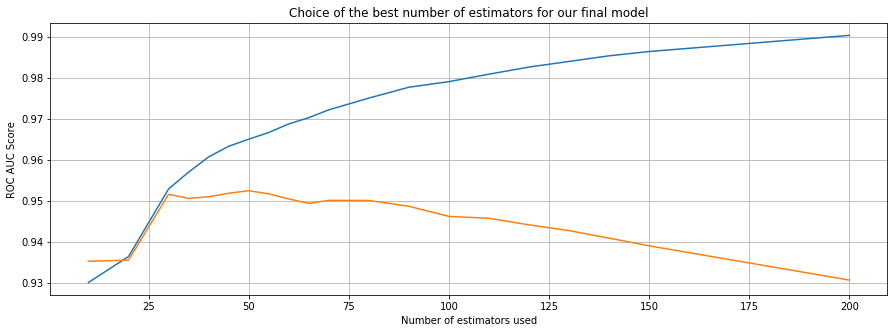

In [132]:
fig = plt.figure(figsize=(15, 5))

plt.plot(N_ESTIMATORS_RANGE, train_scores)
plt.plot(N_ESTIMATORS_RANGE, validate_scores)

plt.title("Choice of the best number of estimators for our final model")
plt.ylabel('ROC AUC Score')
plt.xlabel("Number of estimators used")

plt.grid()
plt.show()

We were previously working with n_estimators = 50. This plot shows that we could reduce overfitting with a choice of **n_estimators = 30**. Hence we now run our new model, which is the final one ! To be even more precise, we could use cross validation but here this quick approach provides us an acceptable result. 

### Let's train our final model with the new hyper parameter. 


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9535288992158002
ROC AUC (Train):         0.9529927922281417

 --- VALIDATE
Accuracy :               0.9547038327526133
ROC AUC (Validate):      0.9516897839996565



 			----------------------------- Feature Importances -----------------------------


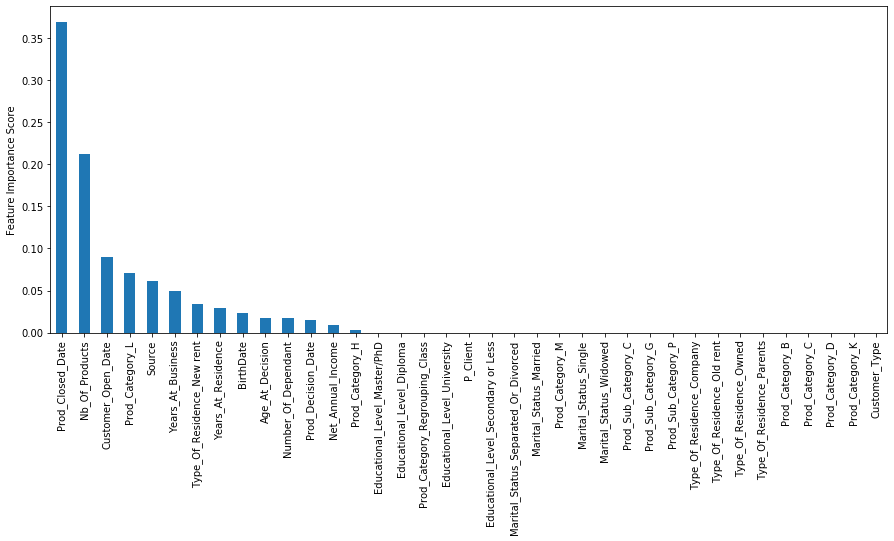

In [133]:
# use xgboost
final_model = xgb.XGBClassifier(n_estimators = 30)

final_model.fit(X_train_s, y_train)

# Predict training and validation set:
y_train_pred = final_model.predict(X_train_s)
y_train_predprob = final_model.predict_proba(X_train_s)[:,1]

y_val_pred = final_model.predict(X_val_s)
y_val_predprob = final_model.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))

print("\n\n\n \t\t\t----------------------------- Feature Importances -----------------------------")

feat_imp = pd.Series(final_model.feature_importances_, index=features_name).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(15, 6))
plt.ylabel('Feature Importance Score')
plt.show()

# 5. Conclusion 

To conclude, we will use our Test Set to make sure that our models are efficient classifiers. Our most effective model seems to be the XGBOOST model. Let's see how it performs on the Test Set, now that we have tuned the hyperparameters.

In [134]:
#Scaling the test set
X_test_s = scaler.transform(X_test)

In [135]:
y_test_pred = final_model.predict(X_test_s)
y_test_predprob = final_model.predict_proba(X_test_s)[:,1]

print("\n ---------------- Final Results ----------------")
print("\n --- TEST")
print("Accuracy :               {}".format(metrics.accuracy_score(y_test, y_test_pred)))
print("ROC AUC (Test):         {}".format(metrics.roc_auc_score(y_test, y_test_predprob)))


 ---------------- Final Results ----------------

 --- TEST
Accuracy :               0.9451672862453532
ROC AUC (Test):         0.9304650626675888


## Plotting the ROC curve

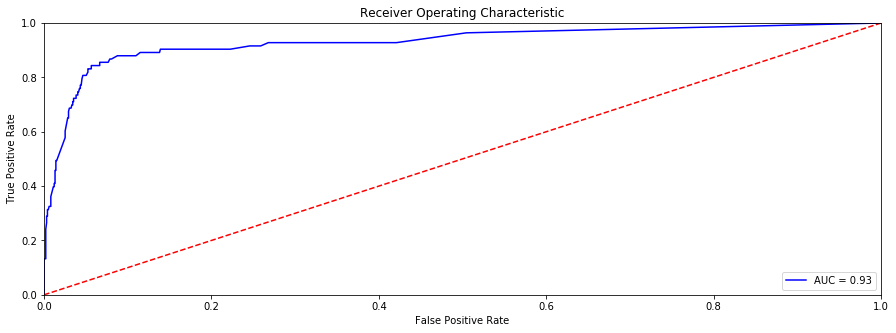

In [136]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_predprob)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(15, 5))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The appearance of this ROC curve indicates a well-performing model, implying that the distribution curves of True Positives and True Negatives scarcely intersect. Despite a slight reduction in the AUC ROC Score compared to the validation set, it's an impressive outcome, and the degree of overfitting is kept within acceptable limits due to our careful hyperparameter tuning and our endeavor to diminish the model's complexity.

Consequently, this notebook presents a relatively straightforward yet effective approach to constructing a model for predicting credit default.